# 0. 데이터 준비
- 캐글 __Dogs vs. Cats__ 데이터셋 
- https://www.kaggle.com/c/dogs-vs-cats/data 에서 다운로드 가능 (캐글 로그인 필요)
- 다운로드 받은 데이터셋 파일(dogs-vs-cats.zip) 압축해제 및 그 안의 train.zip 파일 압축해제

In [1]:
import glob
import numpy as np
import pandas as pd
import os
import shutil
from utils import log_progress

np.random.seed(42)

In [2]:
## 데이터 경로
files = glob.glob('train/*')
files[:10]

['train/cat.8185.jpg',
 'train/dog.621.jpg',
 'train/cat.7547.jpg',
 'train/cat.2244.jpg',
 'train/dog.12162.jpg',
 'train/cat.9436.jpg',
 'train/dog.5712.jpg',
 'train/dog.665.jpg',
 'train/cat.2757.jpg',
 'train/cat.2460.jpg']

In [3]:
## 파일명을 통해 cat 파일, dog 파일 분리
cat_files = [fn for fn in files if 'cat' in fn]
dog_files = [fn for fn in files if 'dog' in fn]

len(cat_files), len(dog_files)

(12500, 12500)

In [4]:
# 이렇게 한번에 해도 됨...
# cat_files = glob.glob('train/cat.*') 
# dog_files = glob.glob('train/dog.*') 

In [5]:
## 학습데이터/검증데이터/테스트데이터 분리 
# cf) sklearn의 sklearn.model_selection.train_test_split() 사용하면 편리 (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

cat_train = np.random.choice(cat_files, size=1500, replace=False)
dog_train = np.random.choice(dog_files, size=1500, replace=False)
cat_files = list(set(cat_files) - set(cat_train))
dog_files = list(set(dog_files) - set(dog_train))

cat_val = np.random.choice(cat_files, size=500, replace=False)
dog_val = np.random.choice(dog_files, size=500, replace=False)
cat_files = list(set(cat_files) - set(cat_val))
dog_files = list(set(dog_files) - set(dog_val))

cat_test = np.random.choice(cat_files, size=500, replace=False)
dog_test = np.random.choice(dog_files, size=500, replace=False)

print('Cat datasets:', cat_train.shape, cat_val.shape, cat_test.shape)
print('Dog datasets:', dog_train.shape, dog_val.shape, dog_test.shape)

Cat datasets: (1500,) (500,) (500,)
Dog datasets: (1500,) (500,) (500,)


In [6]:
## 학습데이터/검증데이터/테스트데이터 각각 별도의 파일을 만들어서 저장
train_dir = 'training_data'
val_dir = 'validation_data'
test_dir = 'test_data'

# cat, dog 데이터를 결합
train_files = np.concatenate([cat_train, dog_train]) 
validate_files = np.concatenate([cat_val, dog_val])
test_files = np.concatenate([cat_test, dog_test])

# 각 경로가 없으면 새로 만듦.
os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

# 학습데이터/검증데이터/테스트데이터 경로에 원본 파일 복사
for fn in log_progress(train_files, name='Training Images'):
    shutil.copy(fn, train_dir)

for fn in log_progress(validate_files, name='Validation Images'):
    shutil.copy(fn, val_dir)
    
for fn in log_progress(test_files, name='Test Images'):
    shutil.copy(fn, test_dir)

# 1. 합성곱 신경망(CNN) 모델 처음부터 구축하기

In [7]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

## 1) 데이터 불러오기

In [8]:
## 학습 데이터 / 검증 데이터 준비
# 이미지의 가로,세로 사이즈는 150,150이고 빨강, 녹색, 파랑(RGB)인 3개의 채널이 있으므로 
# 출력되는 shape은 (데이터 갯수, 150, 150, 3)의 형태. 

IMG_DIM = (150, 150)

# 학습 데이터 
train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[1].split('.')[0].strip() for fn in train_files]

# 검증 데이터
validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\nValidation dataset shape:', validation_imgs.shape) 

Train dataset shape: (5662, 150, 150, 3) 
Validation dataset shape: (5375, 150, 150, 3)


(150, 150, 3)


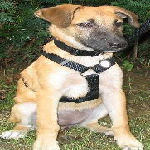

In [9]:
## 데이터 샘플 확인
print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [10]:
## 텍스트 클래스 레이블 인코딩
# cat : 0, dog : 1
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print('Before Encoding : ', train_labels[1495:1505], 
      '\nAfter Encoding : ', train_labels_enc[1495:1505])

Before Encoding :  ['dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog'] 
After Encoding :  [1 1 0 1 0 0 1 1 0 1]


## 2) 데이터 증강 

In [11]:
train_files = glob.glob('training_data/*')
train_files[:10]

['training_data/dog.5712.jpg',
 'training_data/cat.9718.jpg',
 'training_data/dog.1368.jpg',
 'training_data/dog.9425.jpg',
 'training_data/cat.10194.jpg',
 'training_data/dog.5198.jpg',
 'training_data/dog.7967.jpg',
 'training_data/dog.4239.jpg',
 'training_data/dog.8967.jpg',
 'training_data/dog.8253.jpg']

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

Labels: ['cat', 'cat', 'cat', 'cat', 'cat']


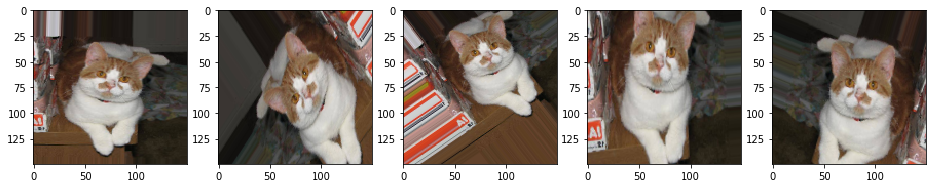

In [13]:
## 데이터 증강된 고양이 이미지 샘플
img_id = 2595
cat_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
cat = [next(cat_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in cat])
l = [ax[i].imshow(cat[i][0][0]) for i in range(0,5)]

Labels: ['dog', 'dog', 'dog', 'dog', 'dog']


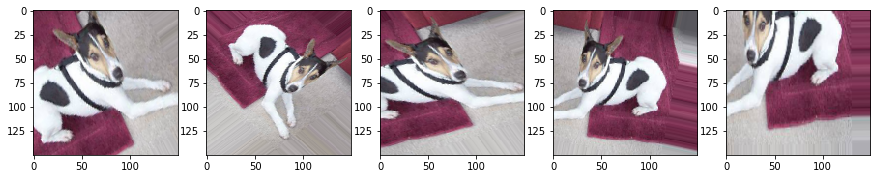

In [14]:
## 데이터 증강된 강아지 이미지 샘플
img_id = 1991
dog_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
dog = [next(dog_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(15, 6))
print('Labels:', [item[1][0] for item in dog])
l = [ax[i].imshow(dog[i][0][0]) for i in range(0,5)]

## 3) 모델 정의

In [20]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

In [21]:
## 하이퍼 파라미터 설정
batch_size = 100 # 배치 사이즈 : 반복해서 모델에 전달되는 데이터의 수
num_classes = 2 # 클래스 개수 (cat, dog)
epochs = 5 #100 # 에포크 : 학습하는동안 모델에 전달하는 전체 데이터 세트를 횟수
input_shape = (150, 150, 3) # 입력되는 이미지 사이즈 (가로사이즈, 세로사이즈, 채널 수)

In [22]:
## CNN 모델 컴파일 및 요약 정보 확인
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

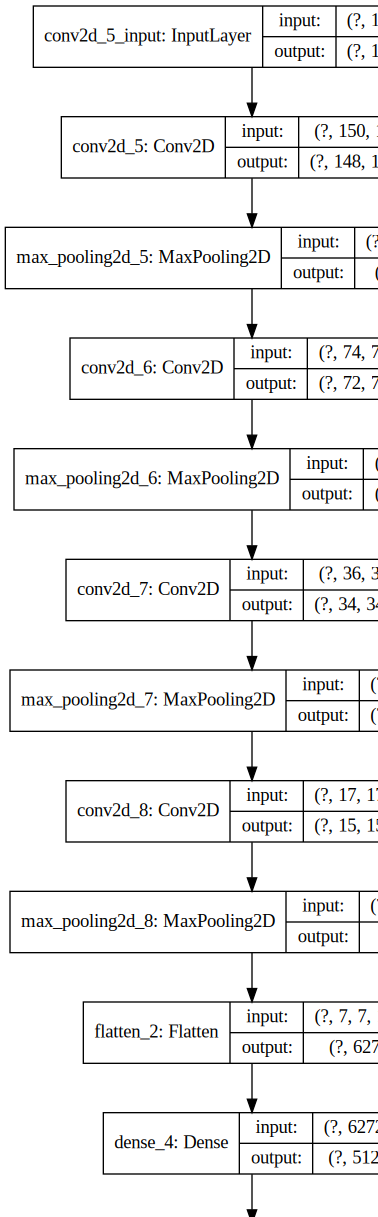

In [23]:
# 모델 다이어그램으로 시각화

from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot 
# model_to_dot : You must install pydot and graphviz for `pydotprint` to work.

SVG(model_to_dot(model, show_shapes=True, 
                 show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))

## 4) 모델 학습

In [ ]:
## 모델 학습
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=batch_size)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=batch_size)

history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=epochs,
                              validation_data=val_generator, validation_steps=50, verbose=1)

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN with Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1, epochs+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
model.save('cats_dogs_cnn_img_aug.h5')

# 2. 사전 훈련된 CNN 모델에 전이학습 활용하기
- VGG-16 : https://arxiv.org/pdf/1409.1556.pdf

In [63]:

import keras

## 1) 데이터 불러오기 (위와 동일)

In [64]:
## 학습 데이터 / 검증 데이터 준비
# 이미지의 가로,세로 사이즈는 150,150이고 빨강, 녹색, 파랑(RGB)인 3개의 채널이 있으므로 
# 출력되는 shape은 (데이터 갯수, 150, 150, 3)의 형태. 

IMG_DIM = (150, 150)

# 학습 데이터 
train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[1].split('.')[0].strip() for fn in train_files]

# 검증 데이터
validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\nValidation dataset shape:', validation_imgs.shape) 

Train dataset shape: (5662, 150, 150, 3) 
Validation dataset shape: (5375, 150, 150, 3)


## 2) 데이터 증강 (위와 동일)

In [65]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

## 3) 모델 정의

In [96]:
## 하이퍼 파라미터 설정
batch_size = 30 # 배치 사이즈 : 반복해서 모델에 전달되는 데이터의 수
num_classes = 2 # 클래스 개수 (cat, dog)
epochs = 5 #100 # 에포크 : 학습하는동안 모델에 전달하는 전체 데이터 세트를 횟수
input_shape = (150, 150, 3) # 입력되는 이미지 사이즈 (가로사이즈, 세로사이즈, 채널 수)

In [97]:
## 사전 학습된 VGG-16 모델 불러오기
from keras.applications import vgg16

vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)

vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

for layer in vgg_model.layers:
    layer.trainable = False

vgg_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [98]:
# VGG-16 모델의 층이 고정되었는지 확인
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7ff314cdd898>,input_13,False
1,<keras.layers.convolutional.Conv2D object at 0x7ff314cdd358>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7ff314d41080>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7ff314d22748>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7ff314bd1f98>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7ff314afb860>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7ff314a81630>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7ff314a81c88>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7ff3149aeb00>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7ff3149376a0>,block3_conv3,False


In [99]:
# VGG-16의 합성곱 블록 4와 5가 학습 가능하도록 설정
vgg_model.trainable = True
set_trainable = False

for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [100]:
# VGG-16 모델의 층이 학습 가능한지 확인

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7ff314cdd898>,input_13,False
1,<keras.layers.convolutional.Conv2D object at 0x7ff314cdd358>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7ff314d41080>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7ff314d22748>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7ff314bd1f98>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7ff314afb860>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7ff314a81630>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7ff314a81c88>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7ff3149aeb00>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7ff3149376a0>,block3_conv3,False


In [101]:
input_shape

(150, 150, 3)

In [102]:
model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-5), 
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Model)              (None, 8192)              14714688  
_________________________________________________________________
dense_19 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 513       
Total params: 19,172,673
Trainable params: 17,437,185
Non-trainable params: 1,735,488
__________________________________

## 4) 모델 학습

In [ ]:
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=batch_size)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=batch_size)

history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=epochs,
                              validation_data=val_generator, validation_steps=50, verbose=1)

Epoch 1/5
100/100 [==============================] - 258s 3s/step - loss: 0.5994 - accuracy: 0.6604 - val_loss: 0.3819 - val_accuracy: 0.8660
Epoch 2/5
100/100 [==============================] - 257s 3s/step - loss: 0.4082 - accuracy: 0.8137 - val_loss: 0.4219 - val_accuracy: 0.9107
Epoch 3/5
 47/100 [=============>................] - ETA: 1:48 - loss: 0.3237 - accuracy: 0.8560

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) with Fine-Tuning & Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1, epochs+1))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")